# Setup

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"  # specify which GPU(s) to be used

In [2]:
import pickle
import torch.nn as nn
import torch
from torch.nn.utils.rnn import pack_padded_sequence
from data_loader import get_loader
from nltk.translate.bleu_score import corpus_bleu
from processData import Vocabulary
from tqdm import tqdm_notebook as tqdm
import torchvision.models as models
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
from scipy.misc import imread, imresize
from PIL import Image
import matplotlib.image as mpimg
from IPython import display
from torchtext.vocab import Vectors, GloVe
from scipy import misc
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

loading annotations into memory...
Done (t=0.87s)
creating index...
index created!
done resizing images...


In [3]:
glove_vectors = pickle.load(open('glove.6B/glove_words.pkl', 'rb'))
glove_vectors = torch.tensor(glove_vectors)

In [4]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=

# Models

In [5]:
#####################################
# Encoder RASNET CNN - pretrained
#####################################
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = models.resnet101(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        self.adaptive_pool = nn.AdaptiveAvgPool2d((14, 14))

    def forward(self, images):
        out = self.adaptive_pool(self.resnet(images))
        # batch_size, img size, imgs size, 2048
        out = out.permute(0, 2, 3, 1)
        return out

In [6]:
####################
# Attention Decoder
####################
class Decoder(nn.Module):

    def __init__(self, vocab_size, use_glove, use_bert):
        super(Decoder, self).__init__()
        self.encoder_dim = 2048
        self.attention_dim = 512
        self.use_bert = use_bert
        if use_glove:
            self.embed_dim = 300
        elif use_bert:
            self.embed_dim = 768
        else:
            self.embed_dim = 512
            
        self.decoder_dim = 512
        self.vocab_size = vocab_size
        self.dropout = 0.5
        
        # soft attention
        self.enc_att = nn.Linear(2048, 512)
        self.dec_att = nn.Linear(512, 512)
        self.att = nn.Linear(512, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        # decoder layers
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(self.embed_dim + self.encoder_dim, self.decoder_dim, bias=True)
        self.h_lin = nn.Linear(self.encoder_dim, self.decoder_dim)
        self.c_lin = nn.Linear(self.encoder_dim, self.decoder_dim)
        self.f_beta = nn.Linear(self.decoder_dim, self.encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(self.decoder_dim, self.vocab_size)

        # init variables
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        
        if not use_bert:
            self.embedding = nn.Embedding(vocab_size, self.embed_dim)
            self.embedding.weight.data.uniform_(-0.1, 0.1)

            # load Glove embeddings
            if use_glove:
                self.embedding.weight = nn.Parameter(glove_vectors)

            # always fine-tune embeddings (even with GloVe)
            for p in self.embedding.parameters():
                p.requires_grad = True
            

    def forward(self, encoder_out, encoded_captions, caption_lengths):    
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        dec_len = [x-1 for x in caption_lengths]
        max_dec_len = max(dec_len)

        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        num_pixels = encoder_out.size(1)

        if not self.use_bert:
            embeddings = self.embedding(encoded_captions)
        elif self.use_bert:
            embeddings = []
            for cap_idx in  encoded_captions:
                
                # padd caption to correct size
                while len(cap_idx) < max_dec_len:
                    cap_idx.append(PAD)
                    
                cap = ' '.join([vocab.idx2word[word_idx.item()] for word_idx in cap_idx])
                cap = u'[CLS] '+cap
                
                tokenized_cap = tokenizer.tokenize(cap)                
                indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_cap)
                tokens_tensor = torch.tensor([indexed_tokens])

                with torch.no_grad():
                    encoded_layers, _ = model(tokens_tensor)

                bert_embedding = encoded_layers[11].squeeze(0)
                
                split_cap = cap.split()
                tokens_embedding = []
                j = 0

                for full_token in split_cap:
                    curr_token = ''
                    x = 0
                    for i,_ in enumerate(tokenized_cap[1:]): # disregard CLS
                        token = tokenized_cap[i+j]
                        piece_embedding = bert_embedding[i+j]
                        
                        # full token
                        if token == full_token and curr_token == '' :
                            tokens_embedding.append(piece_embedding)
                            j += 1
                            break
                        else: # partial token
                            x += 1
                            
                            if curr_token == '':
                                tokens_embedding.append(piece_embedding)
                                curr_token += token.replace('#', '')
                            else:
                                tokens_embedding[-1] = torch.add(tokens_embedding[-1], piece_embedding)
                                curr_token += token.replace('#', '')
                                
                                if curr_token == full_token: # end of partial
                                    j += x
                                    break                            
                
                               
                cap_embedding = torch.stack(tokens_embedding)

                embeddings.append(cap_embedding)
                
            embeddings = torch.stack(embeddings)

        # init hidden state
        avg_enc_out = encoder_out.mean(dim=1)
        h = self.h_lin(avg_enc_out)
        c = self.c_lin(avg_enc_out)

        predictions = torch.zeros(batch_size, max_dec_len, vocab_size)
        alphas = torch.zeros(batch_size, max_dec_len, num_pixels)

        for t in range(max(dec_len)):
            batch_size_t = sum([l > t for l in dec_len ])
            
            # soft-attention
            enc_att = self.enc_att(encoder_out[:batch_size_t])
            dec_att = self.dec_att(h[:batch_size_t])
            att = self.att(self.relu(enc_att + dec_att.unsqueeze(1))).squeeze(2)
            alpha = self.softmax(att)
            attention_weighted_encoding = (encoder_out[:batch_size_t] * alpha.unsqueeze(2)).sum(dim=1)
        
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            batch_embeds = embeddings[:batch_size_t, t, :]  
            cat_val = torch.cat([batch_embeds.double(), attention_weighted_encoding.double()], dim=1)
            
            h, c = self.decode_step(cat_val.float(),(h[:batch_size_t].float(), c[:batch_size_t].float()))
            preds = self.fc(self.dropout(h))
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
            
        # preds, sorted capts, dec lens, attention wieghts
        return predictions, encoded_captions, dec_len, alphas

## Model Setup

In [7]:
# loss
class loss_obj(object):
    def __init__(self):
        self.avg = 0.
        self.sum = 0.
        self.count = 0.

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

PAD = 0
START = 1
END = 2
UNK = 3

grad_clip = 5.
num_epochs = 1
batch_size = 32
decoder_lr = 0.0004

# Load vocabulary wrapper
with open('data/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

# load data
train_loader = get_loader('train', vocab, batch_size)
val_loader = get_loader('val', vocab, batch_size)
test_loader = get_loader('test', vocab, batch_size)

criterion = nn.CrossEntropyLoss()


loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


In [8]:
len(vocab)

8857

In [9]:

#############
# New model
#############

# decoder = Decoder(vocab_size=len(vocab),use_glove=False, use_bert=True) # true = use glove
# decoder_optimizer = torch.optim.Adam(params=decoder.parameters(),lr=decoder_lr)

# encoder = Encoder()

#############
# Load model
#############

encoder = Encoder()
encoder_checkpoint = torch.load('./checkpoints_baseline1/encoder_baseline',map_location='cpu')
encoder.load_state_dict(encoder_checkpoint['model_state_dict'])
decoder = Decoder(vocab_size=len(vocab),use_glove=False, use_bert=False)
decoder_optimizer = torch.optim.Adam(params=decoder.parameters(),lr=decoder_lr)
decoder_checkpoint = torch.load('./checkpoints_baseline1/decoder_baseline',map_location='cpu')
decoder.load_state_dict(decoder_checkpoint['model_state_dict'])
decoder_optimizer.load_state_dict(decoder_checkpoint['optimizer_state_dict'])

## Train

In [10]:
def train():
    print("Started training...")
    for epoch in tqdm(range(num_epochs)):
        decoder.train()
        encoder.train()

        losses = loss_obj()
        num_batches = len(train_loader)

        for i, (imgs, caps, caplens) in enumerate(tqdm(train_loader)):
            if i > 20:
                break

            imgs = encoder(imgs)

            scores, caps_sorted, decode_lengths, alphas = decoder(imgs, caps, caplens)
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]

            targets = caps_sorted[:, 1:]
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

            loss = criterion(scores, targets)
            loss += ((1. - alphas.sum(dim=1)) ** 2).mean()

            decoder_optimizer.zero_grad()
            loss.backward()

            # grad_clip decoder
            for group in decoder_optimizer.param_groups:
                for param in group['params']:
                    if param.grad is not None:
                        param.grad.data.clamp_(-grad_clip, grad_clip)

            decoder_optimizer.step()

            losses.update(loss.item(), sum(decode_lengths))
            print('Batch '+str(i)+'/'+str(num_batches)+' loss:'+str(losses.avg))

            # save model each 100 batches
            if i%60==0 and i!=0:
                print('Batch '+str(i)+'/'+str(num_batches)+' loss:'+str(losses.avg))
                
                 # adjust learning rate (create condition for this)
                for param_group in decoder_optimizer.param_groups:
                    param_group['lr'] = param_group['lr'] * 0.5

                print('saving model...')

                torch.save({
                    'epoch': epoch,
                    'model_state_dict': decoder.state_dict(),
                    'optimizer_state_dict': decoder_optimizer.state_dict(),
                    'loss': loss,
                    }, './checkpoints/decoder_4')

                torch.save({
                    'epoch': epoch,
                    'model_state_dict': encoder.state_dict(),
                    'loss': loss,
                    }, './checkpoints/encoder_4')

                print('model saved')
        
        print('Epoch Loss:'+str(losses.avg))

    print("Completed training...")  


## Validate

In [11]:

%matplotlib inline

def print_sample(hypotheses,references,imgs, alphas, k, show_att):
    print('Baseline Model')
    img_dim = 500 # 14*24
    
    hyp_sentence = []
    for word_idx in hypotheses[k]:
        hyp_sentence.append(vocab.idx2word[word_idx])
    
    ref_sentence = []
    for word_idx in references[k]:
        ref_sentence.append(vocab.idx2word[word_idx])
        
    img = imgs[0][k] 
    misc.imsave('img.jpg', img)
  
    if show_att:
        image = Image.open('img.jpg')
        image = image.resize([img_dim, img_dim], Image.LANCZOS)
        for t in range(len(hyp_sentence)):

            plt.subplot(np.ceil(len(hyp_sentence) / 5.), 5, t + 1)

            plt.text(0, 1, '%s' % (hyp_sentence[t]), color='black', backgroundcolor='white', fontsize=12)
            plt.imshow(image,cmap='gray')
            current_alpha = alphas[0][t, :].detach().numpy()
            alpha = skimage.transform.resize(current_alpha, [img_dim, img_dim])
            if t == 0:
                plt.imshow(alpha, alpha=0,cmap='gray')
            else:
                plt.imshow(alpha, alpha=0.7,cmap='gray')
            plt.axis('off')
    else:
        img = misc.imread('img.jpg')
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
    print('Hypotheses: '+" ".join(hyp_sentence))
    print('References: '+" ".join(ref_sentence))


In [12]:
references = [] 
test_references = []
hypotheses = [] 
all_imgs = []
all_alphas = []

def validate():
    print("Started validation...")
    decoder.eval()
    encoder.eval()

    losses = loss_obj()

    num_batches = len(val_loader)
    print('Batches',num_batches)
    # Batches
    for i, (imgs, caps, caplens) in enumerate(tqdm(val_loader)):
        if i > 0:
            break

        imgs_jpg = imgs.numpy() 
        imgs_jpg = np.swapaxes(np.swapaxes(imgs_jpg, 1, 3), 1, 2)
        
        # Forward prop.
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas = decoder(imgs, caps, caplens)
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        scores_packed = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
        targets_packed = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

        # Calculate loss
        loss = criterion(scores_packed, targets_packed)
        loss += ((1. - alphas.sum(dim=1)) ** 2).mean()

        losses.update(loss.item(), sum(decode_lengths))

         # References
        for j in range(targets.shape[0]):
            img_caps = targets[j].tolist() # validation dataset only has 1 unique caption per img
            clean_cap = [w for w in img_caps if w not in [PAD, START, END]]  # remove pad, start, and end
            img_captions = list(map(lambda c: clean_cap,img_caps))
            test_references.append(clean_cap)
            references.append(img_captions)

        # Hypotheses
        _, preds = torch.max(scores, dim=2)
        preds = preds.tolist()
        temp_preds = list()
        for j, p in enumerate(preds):
            pred = p[:decode_lengths[j]]
            pred = [w for w in pred if w not in [PAD, START, END]]
            temp_preds.append(pred)  # remove pads, start, and end
        preds = temp_preds
        hypotheses.extend(preds)
        
        all_alphas.append(alphas)
        all_imgs.append(imgs_jpg)
    print('ref',len(references))
    print('hy',len(hypotheses))

    bleu = corpus_bleu(references, hypotheses)
    bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    bleu_2 = corpus_bleu(references, hypotheses, weights=(0, 1, 0, 0))
    bleu_3 = corpus_bleu(references, hypotheses, weights=(0, 0, 1, 0))
    bleu_4 = corpus_bleu(references, hypotheses, weights=(0, 0, 0, 1))

    print("Validation loss: "+str(losses.avg))
    print("BLEU: "+str(bleu))
    print("BLEU-1: "+str(bleu_1))
    print("BLEU-2: "+str(bleu_2))
    print("BLEU-3: "+str(bleu_3))
    print("BLEU-4: "+str(bleu_4))
    print_sample(hypotheses, test_references, all_imgs, all_alphas,1,True)
    print("Completed validation...")


In [13]:
%matplotlib inline
def compare_sample(references,bert_hypotheses,glove_hypotheses, baseline_hypotheses, imgs, k):
    img_dim = 500 # 14*24
    
    bert_hyp_sentence = []
    for word_idx in bert_hypotheses[k]:
        bert_hyp_sentence.append(vocab.idx2word[word_idx])
        
    glove_hyp_sentence = []
    for word_idx in glove_hypotheses[k]:
        glove_hyp_sentence.append(vocab.idx2word[word_idx])
    
    baseline_hyp_sentence = []
    for word_idx in baseline_hypotheses[k]:
        baseline_hyp_sentence.append(vocab.idx2word[word_idx])
    
    ref_sentence = []
    for word_idx in references[k]:
        ref_sentence.append(vocab.idx2word[word_idx])
        
    img = imgs[0][k] 
#     print(img)
#     print(imgs)
    misc.imsave('img.jpg', img)
  
    img = misc.imread('img.jpg')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
        
    print('References: '+" ".join(ref_sentence))
    print(' ')
    print('Baseline  : '+" ".join(baseline_hyp_sentence))
    print('GloVe     : '+" ".join(glove_hyp_sentence))
    print('BERT      : '+" ".join(bert_hyp_sentence))
    

In [25]:
references = [] 
bert_hypotheses = []
glove_hypotheses = [] 
baseline_hypotheses = [] 
all_imgs = []

def compare_models():
    
    # load all pre-trained models
    
    encoder_glove = Encoder()
    encoder_checkpoint = torch.load('./checkpoints_glove/encoder_glove',map_location='cpu')
    encoder_glove.load_state_dict(encoder_checkpoint['model_state_dict'])
    decoder_glove = Decoder(vocab_size=len(vocab),use_glove=True, use_bert=False)
    decoder_optimizer = torch.optim.Adam(params=decoder_glove.parameters(),lr=decoder_lr)
    decoder_checkpoint = torch.load('./checkpoints_glove/decoder_glove',map_location='cpu')
    decoder_glove.load_state_dict(decoder_checkpoint['model_state_dict'])
    decoder_optimizer.load_state_dict(decoder_checkpoint['optimizer_state_dict'])

    #########

    encoder_bert = Encoder()
    encoder_checkpoint = torch.load('./checkpoints_bert2/encoder_bert',map_location='cpu')
    encoder_bert.load_state_dict(encoder_checkpoint['model_state_dict'])
    decoder_bert = Decoder(vocab_size=len(vocab),use_glove=False, use_bert=True)
    decoder_optimizer = torch.optim.Adam(params=decoder_bert.parameters(),lr=decoder_lr)
    decoder_checkpoint = torch.load('./checkpoints_bert2/decoder_bert',map_location='cpu')
    decoder_bert.load_state_dict(decoder_checkpoint['model_state_dict'])
    decoder_optimizer.load_state_dict(decoder_checkpoint['optimizer_state_dict'])

    #########

    encoder_baseline = Encoder()
    encoder_checkpoint = torch.load('./checkpoints_baseline1/encoder_baseline',map_location='cpu')
    encoder_baseline.load_state_dict(encoder_checkpoint['model_state_dict'])
    decoder_baseline = Decoder(vocab_size=len(vocab),use_glove=False, use_bert=False)
    decoder_optimizer = torch.optim.Adam(params=decoder_baseline.parameters(),lr=decoder_lr)
    decoder_checkpoint = torch.load('./checkpoints_baseline1/decoder_baseline',map_location='cpu')
    decoder_baseline.load_state_dict(decoder_checkpoint['model_state_dict'])
    decoder_optimizer.load_state_dict(decoder_checkpoint['optimizer_state_dict'])

    print("Started Comparison...")
    decoder_bert.eval()
    encoder_bert.eval()
    decoder_glove.eval()
    decoder_baseline.eval()

    # Batches
    for i, (imgs, caps, caplens,img_ids) in enumerate(tqdm(val_loader)):
        if i > 0:
            break

        imgs_jpg = imgs.numpy() 
        imgs_jpg = np.swapaxes(np.swapaxes(imgs_jpg, 1, 3), 1, 2)
        
        # Forward prop.
        imgs = encoder_bert(imgs)
        scores_bert, caps_sorted_bert,decode_lengths_bert , _ = decoder_bert(imgs, caps, caplens)
        targets = caps_sorted_bert[:, 1:]
        scores_glove, caps_sorted_glove, decode_lengths_glove, _ = decoder_glove(imgs, caps, caplens)
        scores_baseline, caps_sorted_baseline, decode_lengths_baseline, _ = decoder_baseline(imgs, caps, caplens)

         # References
        for j in range(targets.shape[0]):
            img_caps = targets[j].tolist() # validation dataset only has 1 unique caption per img
            clean_cap = [w for w in img_caps if w not in [PAD, START, END]]  # remove pad, start, and end
            img_captions = list(map(lambda c: clean_cap,img_caps))
            references.append(clean_cap)

        # Hypotheses
        _, preds_bert = torch.max(scores_bert, dim=2)
        _, preds_glove = torch.max(scores_glove, dim=2)
        _, preds_baseline = torch.max(scores_baseline, dim=2)
        preds_bert = preds_bert.tolist()
        preds_glove = preds_glove.tolist()
        preds_baseline = preds_baseline.tolist()
        
        temp_preds_bert = list()
        temp_preds_glove = list()
        temp_preds_baseline = list()
        
        for j, p in enumerate(preds_bert):
            pred = preds_bert[j][:decode_lengths_bert[j]]
            pred = [w for w in pred if w not in [PAD, START, END]]
            temp_preds_bert.append(pred)  # remove pads, start, and end
            
            pred = preds_glove[j][:decode_lengths_glove[j]]
            pred = [w for w in pred if w not in [PAD, START, END]]
            temp_preds_glove.append(pred)  # remove pads, start, and end
            
            pred = preds_baseline[j][:decode_lengths_baseline[j]]
            pred = [w for w in pred if w not in [PAD, START, END]]
            temp_preds_baseline.append(pred)  # remove pads, start, and end
            
        bert_hypotheses.extend(temp_preds_bert)
        glove_hypotheses.extend(temp_preds_glove)
        baseline_hypotheses.extend(temp_preds_baseline)
        all_imgs.append(imgs_jpg)
        print(len(bert_hypotheses))
#         print(glove_hypotheses)
#         print(baseline_hypotheses)
        
        compare_sample(references,bert_hypotheses,glove_hypotheses, baseline_hypotheses, all_imgs, 1)



## Run Train/Test

Started Comparison...


/home/zshen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


32


/home/zshen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/zshen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


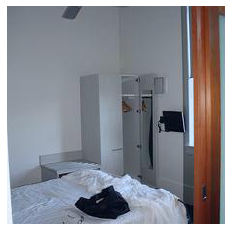

References: a small white room with an unmade bed that has a backpack and a pair of glasses resting on it .
 
Baseline  : a bed bedroom bed with a open bed . has a black on a cat of shoes on on it .
GloVe     : a bedroom bedroom bed with a unmade bed and is a black on a cat of shoes . on it .
BERT      : a small room room with a unmade bed that has a bag and a pair of sunglasses on on it .


In [26]:
compare_models()

In [ ]:
compare_sample(references,bert_hypotheses,glove_hypotheses, baseline_hypotheses, all_imgs, 12)

In [ ]:
validate()